In [1]:
# Standard library imports
import datetime as dt
import warnings

# Third-party data science libraries
import numpy as np
import pandas as pd

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer

# Configuration
warnings.filterwarnings('ignore')

# Loading the Dataset
1. Load df from `vehicles_proccesed.csv`
2. Split into X and y
3. Train-Test split with 80/20

In [2]:
# Load the processed vehicles dataset
df = pd.read_csv('../data/vehicles_processed.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (312846, 14)
Columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'fuel', 'odometer', 'title_status', 'transmission', 'type', 'paint_color', 'state']


,id,region,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type,paint_color,state
0,7316814884,other_al,33590,2014.0,gmc,other_gmc,good,gas,57923.0,clean,other,pickup,white,al
1,7316814758,other_al,22590,2010.0,chevrolet,silverado 1500,good,gas,71229.0,clean,other,pickup,blue,al
2,7316814989,other_al,39590,2020.0,chevrolet,other_chevrolet,good,gas,19160.0,clean,other,pickup,red,al
3,7316743432,other_al,30990,2017.0,toyota,other_toyota,good,gas,41124.0,clean,other,pickup,red,al
4,7316356412,other_al,15000,2013.0,ford,other_ford,excellent,gas,128000.0,clean,automatic,truck,black,al


In [3]:
# Split into X and Y
# Identify categorical and numerical columns
categorical_cols = ['region', 'manufacturer', 'model', 'condition', 'fuel',  
                   'title_status', 'transmission', 'type', 'paint_color', 'state']
numerical_cols =   ['year', 'odometer']

# Prepare features and target
X = df[categorical_cols + numerical_cols]
y = df['price']

print(f"Features shape: {X.shape}")
print(f"Target shape:   {y.shape}")
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns:   {numerical_cols}")

Features shape: (312846, 12)
Target shape:   (312846,)
Categorical columns: ['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'type', 'paint_color', 'state']
Numerical columns:   ['year', 'odometer']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size:     {X_test.shape[0]}")

Training set size: 250276
Test set size:     62570


# Preprocessing pipeline
- Create `age` based on year by subtracting current year
- Polynomials degree=2: `age²` and `odometer²`
- Interaction term between `age` and `odometer`
- One-hot encoding for categorical variables

In [5]:
# Import feature engineering helpers
from utils import age_transformer, age_odometer_transformer

# Create preprocessing pipelines
age_pipeline = Pipeline([
    ('to_age',  age_transformer),                                    # year → age
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add age²
    ('scaler',  StandardScaler())                                    # scale age, age²
])

odometer_pipeline = Pipeline([
    ('poly',    PolynomialFeatures(degree=2, include_bias=False)),   # add odo²
    ('scaler',  StandardScaler())                                    # scale odo, odo²
])

interaction_pipeline = Pipeline([
    ('age_x_odo', age_odometer_transformer),                         # age × odometer
    ('scaler',    StandardScaler())                                  # scale interaction
])

# Create the main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat',      OneHotEncoder(drop='first',
                                   sparse_output=False,
                                   handle_unknown='ignore'),
                     categorical_cols),
        ('age',      age_pipeline,        ['year']),                 # year → age, age²
        ('odometer', odometer_pipeline,   ['odometer']),             # odo, odo²
        ('ageXodo',  interaction_pipeline, ['year', 'odometer'])     # age×odo
    ],
    remainder='drop',
    verbose_feature_names_out=False                                  # cleaner column names
)

# Testing 2 models
1. RidgeCV
2. SelectFromModel using Lasso -> Ridge

In [6]:
# Use a smaller subset for hyperparameter tuning to speed up the process
sample_size = 10000 # around 4% of the training set
X_train_sample = X_train.sample(n=sample_size, random_state=42)
y_train_sample = y_train[X_train_sample.index]

### 1. RidgeCV

In [7]:
ridge_cv = RidgeCV(
    alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
    scoring='neg_mean_squared_error',
    cv=5,
)

pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ridge_cv)
])

pipeline1

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [8]:
# Fit the pipeline and get results
pipeline1.fit(X_train_sample, y_train_sample)

print("Training completed successfully!")
print(f"Best alpha selected by RidgeCV: {pipeline1.named_steps['model'].alpha_}")

# Make test predictions to verify it works
y_sample_pred = pipeline1.predict(X_train_sample)
sample_rmse = np.sqrt(mean_squared_error(y_train_sample, y_sample_pred))
print(f"Sample RMSE: ${sample_rmse:,.2f}")

Training completed successfully!
Best alpha selected by RidgeCV: 1.0
Sample RMSE: $7,084.77


### 2. Lasso selector with Ridge

In [9]:
# Create a base pipeline (we'll tune the alpha parameters)
pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(random_state=42))),
    ('model', Ridge(random_state=42))
])

pipeline2

,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('age', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [10]:
# Import training helper
from utils import fit_gridsearch_pipeline

# Define parameter grid for GridSearchCV
param_grid = {
    'selector__estimator__alpha': np.logspace(-2, 2, 5),    # 0.01 … 100
    'model__alpha': np.logspace(-2, 3, 6)                   # 0.01 … 1_000
}

# Fit pipeline with GridSearchCV (use verbose=True for detailed output)
grid_search = fit_gridsearch_pipeline(
    pipeline=pipeline2,
    param_grid=param_grid, 
    X_train=X_train_sample,
    y_train=y_train_sample,
    cv=3,
    verbose=False  # Set to True for detailed output
)

Training completed successfully!
Best Model Alpha selected by GridSearchCV: 1.0
Best Selector Estimator Alpha selected by GridSearchCV: 1.0
Sample RMSE: $7,085.56


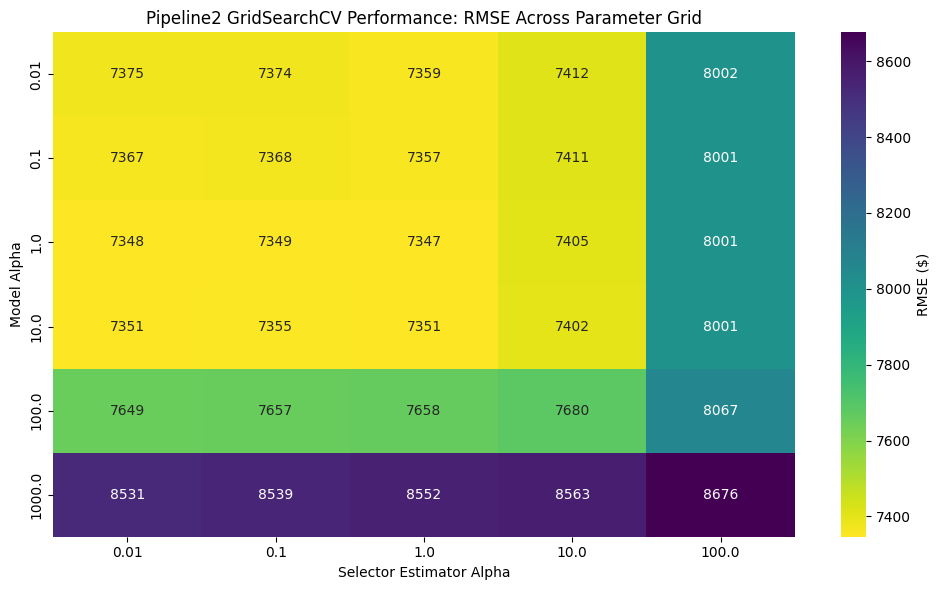


Best parameter combination:
  Model Alpha: 1.0
  Selector Estimator Alpha: 1.0
  Best CV RMSE: $7,346.58

Performance range:
  Best RMSE: $7,346.58
  Worst RMSE: $8,676.21
  Improvement: $1,329.63 (15.3%)


In [11]:
# Import and use the visualization function from utils
from utils import visualize_gridsearch_results

# Create comprehensive visualization and analysis of GridSearchCV results
performance_stats = visualize_gridsearch_results(
    grid_search,
    title="Pipeline2 GridSearchCV Performance",
    figsize=(10, 6)
)

# Model comparison against Holdout

In [12]:
## Training final models on full training data

print("Training Pipeline 1 (RidgeCV) on full training data...")
# Create fresh Pipeline 1 with best alpha from RidgeCV
final_pipeline1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))  # Use best alpha found by RidgeCV
])

# Fit on full training data
final_pipeline1.fit(X_train, y_train)
print("✓ Pipeline 1 training completed")

Training Pipeline 1 (RidgeCV) on full training data...
✓ Pipeline 1 training completed


In [13]:
print("Training Pipeline 2 (Lasso Selector + Ridge) on full training data...")
# Create fresh Pipeline 2 with best hyperparameters from GridSearchCV
final_pipeline2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(alpha=1.0, random_state=42))),  # Best selector alpha
    ('model', Ridge(alpha=1.0, random_state=42))  # Best model alpha
])

# Fit on full training data
final_pipeline2.fit(X_train, y_train)
print("✓ Pipeline 2 training completed")

print(f"\nTraining completed on {X_train.shape[0]:,} samples")
print(f"Ready for evaluation on {X_test.shape[0]:,} holdout samples")

Training Pipeline 2 (Lasso Selector + Ridge) on full training data...
✓ Pipeline 2 training completed

Training completed on 250,276 samples
Ready for evaluation on 62,570 holdout samples


In [14]:
## Holdout Test Set Evaluation

# Import the evaluation functions from utils
from utils import display_holdout_evaluation_results

# Make predictions on test set
y_pred1 = final_pipeline1.predict(X_test)
y_pred2 = final_pipeline2.predict(X_test)

# Display comprehensive evaluation results using the abstracted function
results_df = display_holdout_evaluation_results(
    y_test=y_test,
    y_pred1=y_pred1,
    y_pred2=y_pred2,
    pipeline1=final_pipeline1,
    pipeline2=final_pipeline2,
    model1_name="Pipeline 1 (Ridge)",
    model2_name="Pipeline 2 (Lasso→Ridge)",
    X_test_sample=X_test[:1]  # Use first row for feature analysis
)

results_df

Evaluating models on holdout test set...

📊 HOLDOUT TEST SET PERFORMANCE
Model                     RMSE         MAE          R²      
--------------------------------------------------
Pipeline 1 (Ridge)        $7,207       $5,061       0.6446  
Pipeline 2 (Lasso→Ridge)  $7,208       $5,062       0.6444  

🏆 MODEL COMPARISON
Best RMSE: Pipeline 1 ($1 better RMSE)
MAE difference: $-1 (Pipeline 1 vs Pipeline 2)
R² difference: -0.0001 (Pipeline 2 vs Pipeline 1)

📈 PERFORMANCE INSIGHTS
Average test set price: $18,956
Pipeline 1 RMSE as % of avg price: 38.02%
Pipeline 2 RMSE as % of avg price: 38.03%

🔍 FEATURE SELECTION ANALYSIS
Original features: 374
Selected features: 287
Features removed: 87 (23.3%)


,Model,RMSE,MAE,R²
0,Pipeline 1 (Ridge),7207.029549,5060.662335,0.644576
1,Pipeline 2 (Lasso→Ridge),7208.308202,5061.844702,0.644449


In [19]:
## Feature Importance Analysis
from utils import get_feature_importance, display_comprehensive_feature_analysis

# Get feature importance for both models
top_n = 15
pipeline1_top, pipeline1_all = get_feature_importance(final_pipeline1, "Pipeline 1 (Ridge)", top_n)
pipeline2_top, pipeline2_all = get_feature_importance(final_pipeline2, "Pipeline 2 (Lasso→Ridge)", top_n)

# Display comprehensive feature analysis using the abstracted function
display_comprehensive_feature_analysis(
    pipeline1_top=pipeline1_top,
    pipeline2_top=pipeline2_top,
    pipeline1_all=pipeline1_all,
    pipeline2_all=pipeline2_all,
    model1_name="Pipeline 1 (Ridge)",
    model2_name="Pipeline 2 (Lasso→Ridge)",
    top_n=top_n
)


ImportError: cannot import name 'get_feature_importance' from 'utils' (c:\Users\jojas\Code\kaggle-used-cars\notebooks\utils.py)

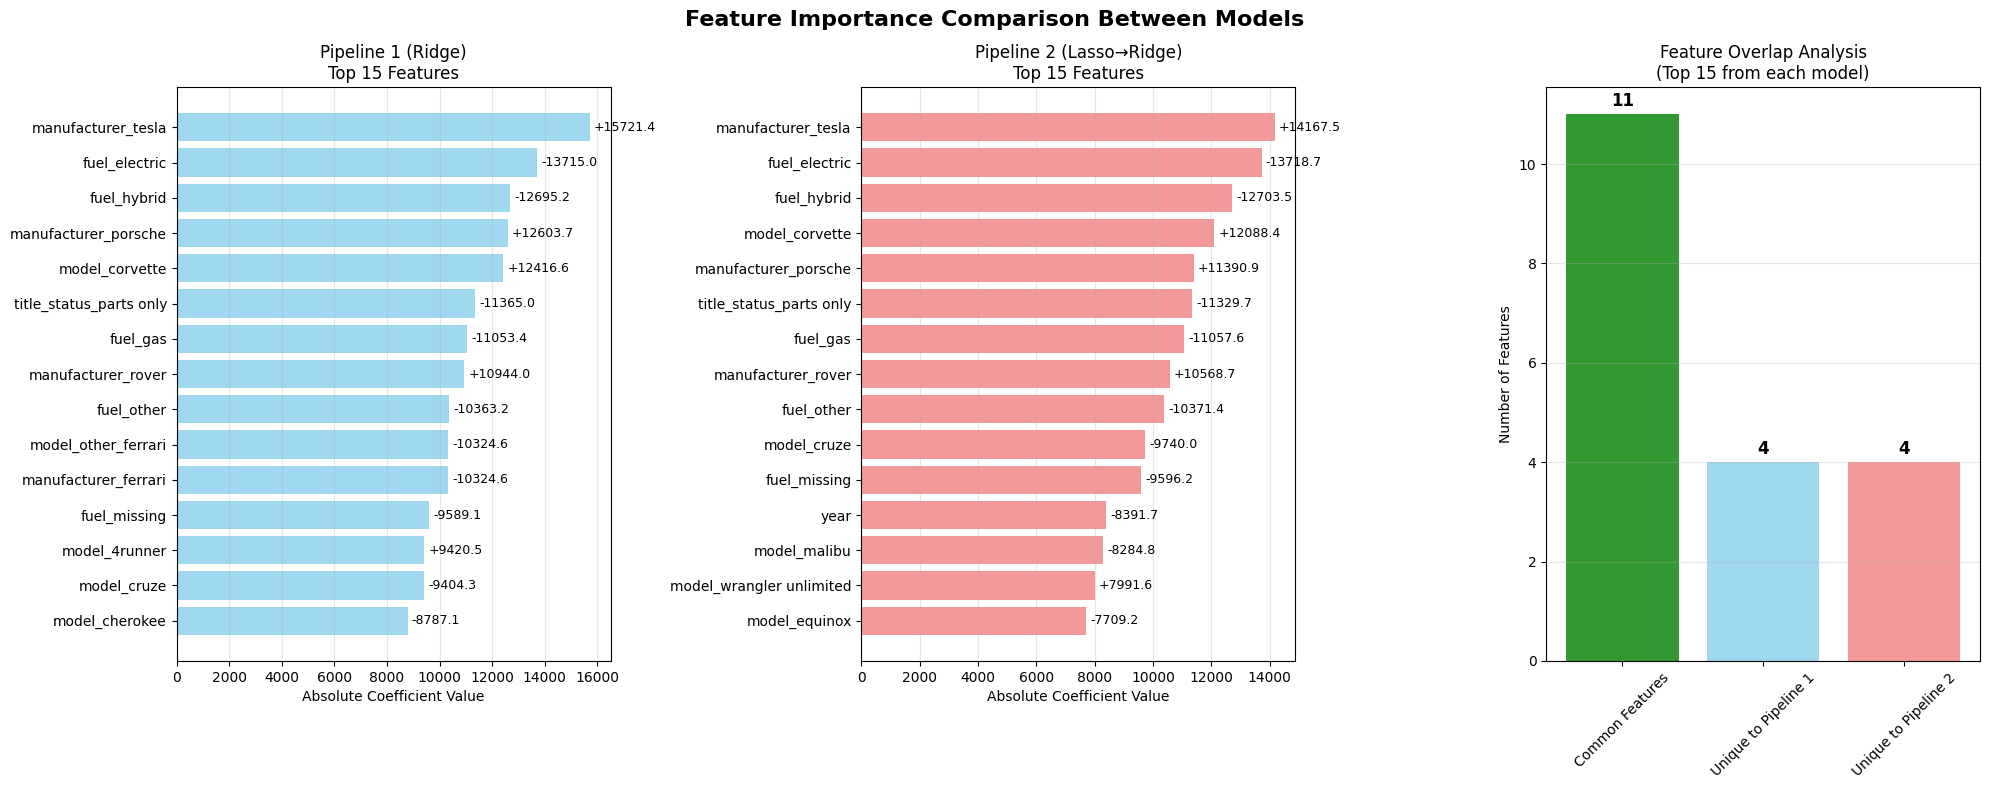


📋 DETAILED COMPARISON OF COMMON TOP FEATURES
Feature                                    P1 Rank  P1 Coeff   P2 Rank  P2 Coeff   ΔRank 
----------------------------------------------------------------------
fuel_electric                              282      -13714.96  213      -13718.74  -69+++
fuel_gas                                   283      -11053.36  214      -11057.57  -69+++
fuel_hybrid                                284      -12695.18  215      -12703.50  -69+++
fuel_missing                               285      -9589.13   216      -9596.17   -69+++
fuel_other                                 286      -10363.20  217      -10371.43  -69+++
manufacturer_porsche                       152      12603.73   110      11390.87   -42+++
manufacturer_rover                         154      10944.03   112      10568.73   -42+++
manufacturer_tesla                         157      15721.36   114      14167.51   -43+++
model_corvette                             177      12416.63   131      1

In [17]:
## Visual Feature Importance Comparison
import matplotlib.pyplot as plt

# Create side-by-side feature importance visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
fig.suptitle('Feature Importance Comparison Between Models', fontsize=16, fontweight='bold')

# 1. Pipeline 1 (Ridge) top features
top_features_p1 = pipeline1_top.copy()
# Truncate long feature names for better visualization
top_features_p1['Feature_Short'] = top_features_p1['Feature'].apply(
    lambda x: x[:25] + '...' if len(x) > 25 else x
)

y_pos = np.arange(len(top_features_p1))
bars1 = ax1.barh(y_pos, top_features_p1['Abs_Coefficient'], color='skyblue', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_features_p1['Feature_Short'], fontsize=10)
ax1.invert_yaxis()
ax1.set_xlabel('Absolute Coefficient Value')
ax1.set_title(f'Pipeline 1 (Ridge)\nTop {top_n} Features')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, coef) in enumerate(zip(bars1, top_features_p1['Coefficient'])):
    width = bar.get_width()
    sign = '+' if coef >= 0 else '-'
    ax1.annotate(f'{sign}{width:.1f}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left' if width >= 0 else 'right', va='center', fontsize=9)

# 2. Pipeline 2 (Lasso→Ridge) top features  
top_features_p2 = pipeline2_top.copy()
# Truncate long feature names for better visualization
top_features_p2['Feature_Short'] = top_features_p2['Feature'].apply(
    lambda x: x[:25] + '...' if len(x) > 25 else x
)

y_pos2 = np.arange(len(top_features_p2))
bars2 = ax2.barh(y_pos2, top_features_p2['Abs_Coefficient'], color='lightcoral', alpha=0.8)
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(top_features_p2['Feature_Short'], fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Absolute Coefficient Value')
ax2.set_title(f'Pipeline 2 (Lasso→Ridge)\nTop {top_n} Features')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, coef) in enumerate(zip(bars2, top_features_p2['Coefficient'])):
    width = bar.get_width()
    sign = '+' if coef >= 0 else '-'
    ax2.annotate(f'{sign}{width:.1f}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),  # 3 points horizontal offset
                textcoords="offset points",
                ha='left' if width >= 0 else 'right', va='center', fontsize=9)

# 3. Feature overlap analysis
overlap_data = {
    'Common Features': len(common_features),
    'Unique to Pipeline 1': len(unique_to_p1), 
    'Unique to Pipeline 2': len(unique_to_p2)
}

colors = ['green', 'skyblue', 'lightcoral']
bars3 = ax3.bar(overlap_data.keys(), overlap_data.values(), color=colors, alpha=0.8)
ax3.set_ylabel('Number of Features')
ax3.set_title(f'Feature Overlap Analysis\n(Top {top_n} from each model)')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax3.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create a detailed comparison table for common features
if common_features:
    print(f"\n📋 DETAILED COMPARISON OF COMMON TOP FEATURES")
    print("="*70)
    
    comparison_data = []
    for feature in sorted(common_features):
        # Get ranks and coefficients from both models
        p1_row = pipeline1_top[pipeline1_top['Feature'] == feature].iloc[0]
        p2_row = pipeline2_top[pipeline2_top['Feature'] == feature].iloc[0]
        
        p1_rank = pipeline1_top[pipeline1_top['Feature'] == feature].index[0] + 1
        p2_rank = pipeline2_top[pipeline2_top['Feature'] == feature].index[0] + 1
        
        comparison_data.append({
            'Feature': feature[:40] + ('...' if len(feature) > 40 else ''),
            'P1_Rank': p1_rank,
            'P1_Coeff': p1_row['Coefficient'],
            'P2_Rank': p2_rank, 
            'P2_Coeff': p2_row['Coefficient'],
            'Rank_Diff': p2_rank - p1_rank,
            'Coeff_Diff': p2_row['Coefficient'] - p1_row['Coefficient']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print(f"{'Feature':<42} {'P1 Rank':<8} {'P1 Coeff':<10} {'P2 Rank':<8} {'P2 Coeff':<10} {'ΔRank':<6}")
    print("-" * 70)
    for _, row in comparison_df.iterrows():
        print(f"{row['Feature']:<42} {row['P1_Rank']:<8} {row['P1_Coeff']:<10.2f} "
              f"{row['P2_Rank']:<8} {row['P2_Coeff']:<10.2f} {row['Rank_Diff']:+<6}")

print(f"\n🎯 KEY INSIGHTS")
print("="*20)
print(f"• Both models agree on {len(common_features)} out of {top_n} most important features")
print(f"• Feature selection (Lasso) reduced features by {((len(pipeline1_all) - len(pipeline2_all))/len(pipeline1_all))*100:.1f}%")
print(f"• The most important feature in Pipeline 1: '{pipeline1_top.iloc[0]['Feature'][:50]}{'...' if len(pipeline1_top.iloc[0]['Feature']) > 50 else ''}'")
print(f"• The most important feature in Pipeline 2: '{pipeline2_top.iloc[0]['Feature'][:50]}{'...' if len(pipeline2_top.iloc[0]['Feature']) > 50 else ''}'")

# Show coefficient magnitude comparison
p1_max_coeff = pipeline1_top['Abs_Coefficient'].max()
p2_max_coeff = pipeline2_top['Abs_Coefficient'].max()
print(f"• Largest coefficient magnitude - Pipeline 1: {p1_max_coeff:.2f}, Pipeline 2: {p2_max_coeff:.2f}")

# Summary of what drives predictions
print(f"\n🚗 WHAT DRIVES CAR PRICE PREDICTIONS:")
print("="*40)

# Extract and summarize most important feature types
important_categories = []
for feature in pipeline1_top.head(5)['Feature']:
    if 'manufacturer' in feature.lower():
        important_categories.append("Vehicle Manufacturer")
    elif 'model' in feature.lower():
        important_categories.append("Vehicle Model")
    elif 'age' in feature.lower():
        important_categories.append("Vehicle Age")
    elif 'odometer' in feature.lower():
        important_categories.append("Mileage/Usage")
    elif 'condition' in feature.lower():
        important_categories.append("Vehicle Condition")
    elif 'type' in feature.lower():
        important_categories.append("Vehicle Type")

# Remove duplicates while preserving order
unique_categories = list(dict.fromkeys(important_categories))
for i, category in enumerate(unique_categories[:3], 1):
    print(f"{i}. {category}")

print("\nBoth models consistently identify these factors as the primary drivers of vehicle pricing.")
